Mounting Google Drive Storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Changing to Working Directory

In [ ]:
import os
os.chdir('/content/drive/Shareddrives/SP\'21 : Course Project : SLR/Notebooks/Datasets/VoxLingua107/Feature Files')
featureFiles = os.listdir()
print('Current Directory :', os.getcwd(), '\nDirectory Contents:\n', featureFiles)

Current Directory : /content/drive/Shareddrives/SP'21 : Course Project : SLR/Notebooks/Datasets/VoxLingua107/Feature Files 
Directory Contents:
 ['bnAudioFeatures.npy', 'enAudioFeatures.npy', 'guAudioFeatures.npy', 'hiAudioFeatures.npy', 'knAudioFeatures.npy', 'mlAudioFeatures.npy', 'neAudioFeatures.npy', 'taAudioFeatures.npy', 'outputLabels.npy', 'padInformationMatrix.npy', 'featureMatrix.npy']


Required Imports

In [ ]:
import numpy as np

Loading Feature and Label Files

In [ ]:
featureMatrix = np.load('featureMatrix.npy', allow_pickle = True)
outputLabelMatrix = np.load('outputLabels.npy', allow_pickle = True)
padInfoMatrix = np.load('padInformationMatrix.npy', allow_pickle = True)

print(outputLabelMatrix.shape, featureMatrix.shape, padInfoMatrix.shape)

(8, 1000) (8, 1000, 39, 862) (8, 1000)


In [ ]:
nLanguages = 8
maxFiles = 1000

In [ ]:
combinedFeatureList = []
combinedOutputLabelList = []

for lanIndex in range(nLanguages):
  for fileIndex in range(maxFiles):
    combinedFeatureList.append(featureMatrix[lanIndex][fileIndex].flatten())
    combinedOutputLabelList.append(outputLabelMatrix[lanIndex][fileIndex])

combinedFeatureList = np.array(combinedFeatureList)
combinedOutputLabelList = np.array(combinedOutputLabelList)

print(combinedFeatureList.shape, combinedOutputLabelList.shape)

(8000, 33618) (8000,)


One-Hot Encoding for Output Labels

Original Encoding
*   0 - Padded Region
*   1 - Bengali (bn)
*   2 - English (en)
*   3 - Gujarati (gu)
*   4 - Hindi (hi)
*   5 - Kannada (kn)
*   6 - Malayalam (ml)
*   7 - Nepali (ne)
*   8 - Tamil (ta)



In [ ]:
encodedOutputLabelList = np.zeros((combinedOutputLabelList.shape[0], combinedOutputLabelList.max() + 1))
encodedOutputLabelList[np.arange(combinedOutputLabelList.shape[0]), combinedOutputLabelList] = 1
print(encodedOutputLabelList.shape)

(8000, 9)


Training Models and Performing Classification

In [ ]:
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(combinedFeatureList, encodedOutputLabelList, test_size=0.2, random_state = 33)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(6400, 33618) (1600, 33618) (6400, 9) (1600, 9)


Model : Feed-Forward Neural Network

In [ ]:
model = Sequential()
model.add(Dense(200, input_shape = (combinedFeatureList.shape[1], ), activation = 'relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(encodedOutputLabelList.shape[1], activation = 'softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               6723800   
_________________________________________________________________
dense_6 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 459       
Total params: 6,774,559
Trainable params: 6,774,559
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, epochs = 22, batch_size = 2000, validation_data=(x_test, y_test))

Epoch 1/22
4/4 [==============================] - 5s 1s/step - loss: 0.1663 - accuracy: 0.7522 - val_loss: 0.7252 - val_accuracy: 0.3237
Epoch 2/22
4/4 [==============================] - 4s 988ms/step - loss: 0.1468 - accuracy: 0.7870 - val_loss: 0.7030 - val_accuracy: 0.3069
Epoch 3/22
4/4 [==============================] - 4s 1s/step - loss: 0.1315 - accuracy: 0.8127 - val_loss: 0.6917 - val_accuracy: 0.3194
Epoch 4/22
4/4 [==============================] - 4s 991ms/step - loss: 0.1178 - accuracy: 0.8336 - val_loss: 0.6939 - val_accuracy: 0.3137
Epoch 5/22
4/4 [==============================] - 4s 976ms/step - loss: 0.1127 - accuracy: 0.8389 - val_loss: 0.6887 - val_accuracy: 0.3131
Epoch 6/22
4/4 [==============================] - 4s 997ms/step - loss: 0.1067 - accuracy: 0.8523 - val_loss: 0.6917 - val_accuracy: 0.3125
Epoch 7/22
4/4 [==============================] - 4s 982ms/step - loss: 0.0998 - accuracy: 0.8652 - val_loss: 0.6785 - val_accuracy: 0.3162
Epoch 8/22
4/4 [==========

In [ ]:
trueOutput = [np.where(r==1)[0][0] for r in encodedOutputLabelList]
predictedOutput = model.predict_classes(combinedFeatureList)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(trueOutput, predictedOutput)

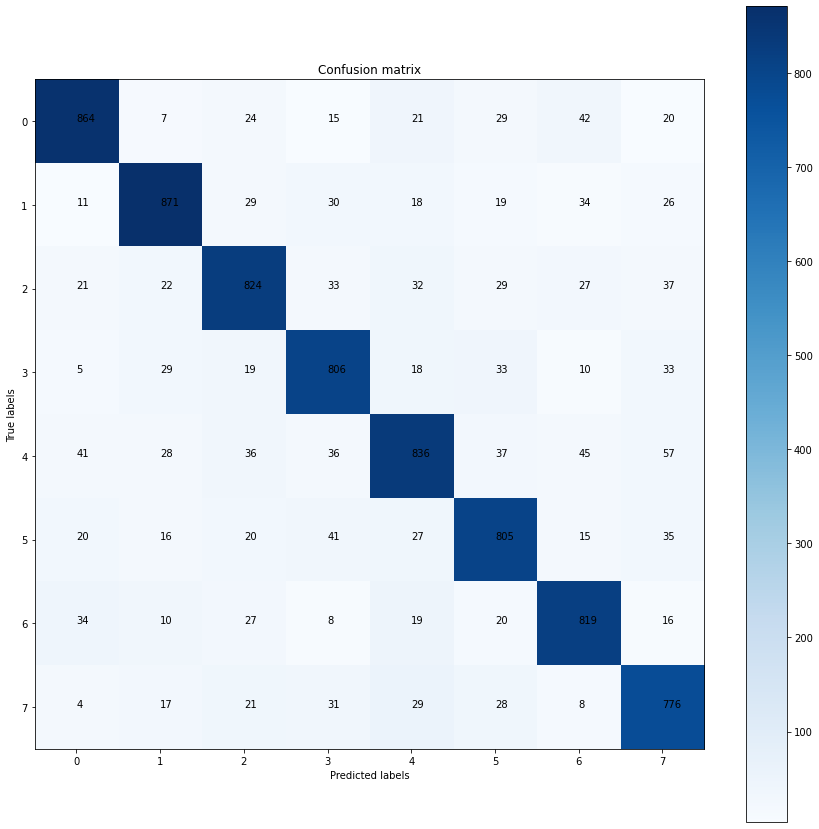

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (15, 15))
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion matrix')
for i in range(8):
  for j in range(8):
    plt.annotate(cm[i][j], (i, j))
plt.colorbar()
plt.show()

Model : Convolutional Neural Network

In [61]:
combinedFeatureList = []
combinedOutputLabelList = []

for lanIndex in range(nLanguages):
  for fileIndex in range(maxFiles):
    combinedFeatureList.append(featureMatrix[lanIndex][fileIndex])
    combinedOutputLabelList.append(outputLabelMatrix[lanIndex][fileIndex])

combinedFeatureList = np.array(combinedFeatureList)
combinedOutputLabelList = np.array(combinedOutputLabelList)

combinedFeatureList = combinedFeatureList.reshape(combinedFeatureList.shape[0], combinedFeatureList.shape[1], combinedFeatureList.shape[2], 1)

print(combinedFeatureList.shape, combinedOutputLabelList.shape)

(8000, 39, 862, 1) (8000,)


In [62]:
x_train, x_test, y_train, y_test = train_test_split(combinedFeatureList, encodedOutputLabelList, test_size=0.2, random_state = 33)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(6400, 39, 862, 1) (1600, 39, 862, 1) (6400, 9) (1600, 9)


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = combinedFeatureList.shape[1:]))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(encodedOutputLabelList.shape[1], activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 37, 860, 32)       320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 18, 430, 32)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 428, 64)       18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 214, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 6, 212, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 3, 106, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 104, 256)      

In [ ]:
history = model.fit(x_train, y_train, epochs = 3, batch_size = 500, validation_data=(x_test, y_test))

Epoch 1/3
13/13 [==============================] - 341s 26s/step - loss: 0.4721 - accuracy: 0.8542 - val_loss: 1.0237 - val_accuracy: 0.6812
Epoch 2/3
13/13 [==============================] - 339s 26s/step - loss: 0.4196 - accuracy: 0.8662 - val_loss: 1.0004 - val_accuracy: 0.6988
Epoch 3/3
13/13 [==============================] - 337s 26s/step - loss: 0.3512 - accuracy: 0.8941 - val_loss: 1.0417 - val_accuracy: 0.6994


In [ ]:
trueOutput = [np.where(r==1)[0][0] for r in encodedOutputLabelList]
predictedOutput = model.predict_classes(combinedFeatureList)

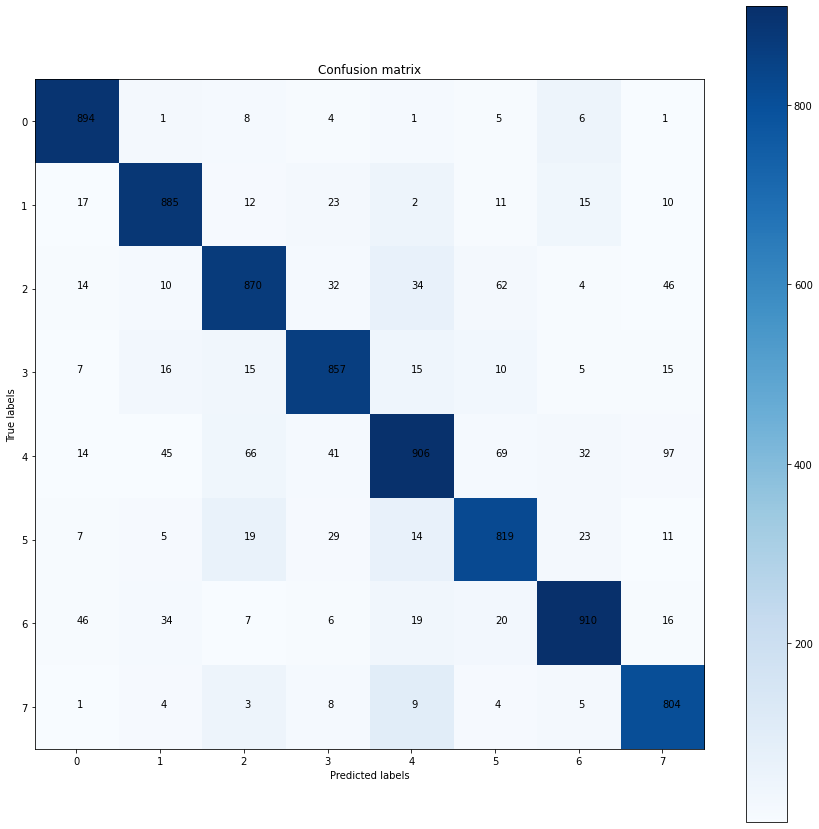

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(trueOutput, predictedOutput)

%matplotlib inline
plt.figure(figsize = (15, 15))
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion matrix')
for i in range(8):
  for j in range(8):
    plt.annotate(cm[i][j], (i, j))
plt.colorbar()
plt.show()

In [ ]:
combinedFeatureList = []
combinedOutputLabelList = []

for lanIndex in range(nLanguages):
  for fileIndex in range(maxFiles):
    combinedFeatureList.append(featureMatrix[lanIndex][fileIndex].flatten())
    combinedOutputLabelList.append(outputLabelMatrix[lanIndex][fileIndex])

combinedFeatureList = np.array(combinedFeatureList)
combinedOutputLabelList = np.array(combinedOutputLabelList)

print(combinedFeatureList.shape, combinedOutputLabelList.shape)

(8000, 33618) (8000,)


In [ ]:
from sklearn.decomposition import PCA

pcaOut = PCA(nLanguages)
pcaOut = pcaOut.fit_transform(combinedFeatureList)

In [ ]:
import pandas as pd
pca_df = pd.DataFrame(columns = ['pca1','pca2'])

pca_df['pca1'] = pcaOut[:,0]
pca_df['pca2'] = pcaOut[:,1]

In [ ]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(15, 15))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 1080x1080 with 1 Axes>,
 [Text(-1591.0432, -241.42383, '0'),
  Text(1437.0814, 506.78357, '1'),
  Text(-1315.3077, -35.11679, '2'),
  Text(-51.841675, 438.09058, '3'),
  Text(-661.1317, -411.00916, '4'),
  Text(-268.86447, -180.39886, '5'),
  Text(-1149.4946, -314.02808, '6'),
  Text(-336.0581, -205.71971, '7')])

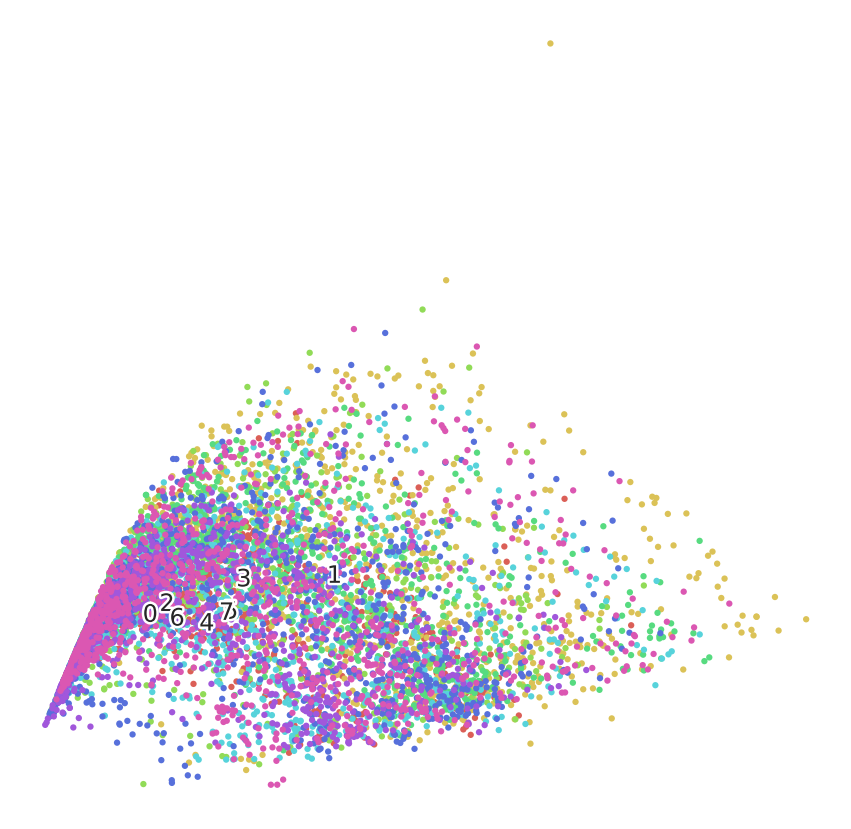

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

top_two_comp = pca_df[['pca1','pca2']]
fashion_scatter(top_two_comp.values,(combinedOutputLabelList - 1))

Model : LSTM

In [67]:
from keras.layers import LSTM

combinedFeatureList = combinedFeatureList.reshape(combinedFeatureList.shape[0], combinedFeatureList.shape[1], combinedFeatureList.shape[2])



print(combinedFeatureList.shape, combinedOutputLabelList.shape)

x_train, x_test, y_train, y_test = train_test_split(combinedFeatureList, encodedOutputLabelList, test_size=0.2, random_state = 33)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8000, 39, 862) (8000,)
(6400, 39, 862) (1600, 39, 862) (6400, 9) (1600, 9)


In [73]:
combinedFeatureList.shape[1:]

(39, 862)

In [83]:
model3 = Sequential()

model3.add(LSTM(128, input_shape = combinedFeatureList.shape[1:]))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(9, activation = 'softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 128)               507392    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 9)                 297       
Total params: 518,025
Trainable params: 518,025
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = model3.fit(x_train, y_train, epochs = 11, batch_size = 1000, validation_data=(x_test, y_test))

Epoch 1/11
7/7 [==============================] - 16s 2s/step - loss: 2.2095 - accuracy: 0.1151 - val_loss: 2.1877 - val_accuracy: 0.1312
Epoch 2/11
7/7 [==============================] - 13s 2s/step - loss: 2.1163 - accuracy: 0.2409 - val_loss: 2.1705 - val_accuracy: 0.1238
Epoch 3/11
7/7 [==============================] - 13s 2s/step - loss: 2.0406 - accuracy: 0.3084 - val_loss: 2.1575 - val_accuracy: 0.1275
Epoch 4/11
7/7 [==============================] - 13s 2s/step - loss: 1.9485 - accuracy: 0.3669 - val_loss: 2.1480 - val_accuracy: 0.1338
Epoch 5/11
7/7 [==============================] - 13s 2s/step - loss: 1.8251 - accuracy: 0.4405 - val_loss: 2.1474 - val_accuracy: 0.1375
Epoch 6/11
7/7 [==============================] - 13s 2s/step - loss: 1.6670 - accuracy: 0.4975 - val_loss: 2.1800 - val_accuracy: 0.1462
Epoch 7/11
7/7 [==============================] - 13s 2s/step - loss: 1.4587 - accuracy: 0.5766 - val_loss: 2.2589 - val_accuracy: 0.1437
Epoch 8/11
7/7 [==================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


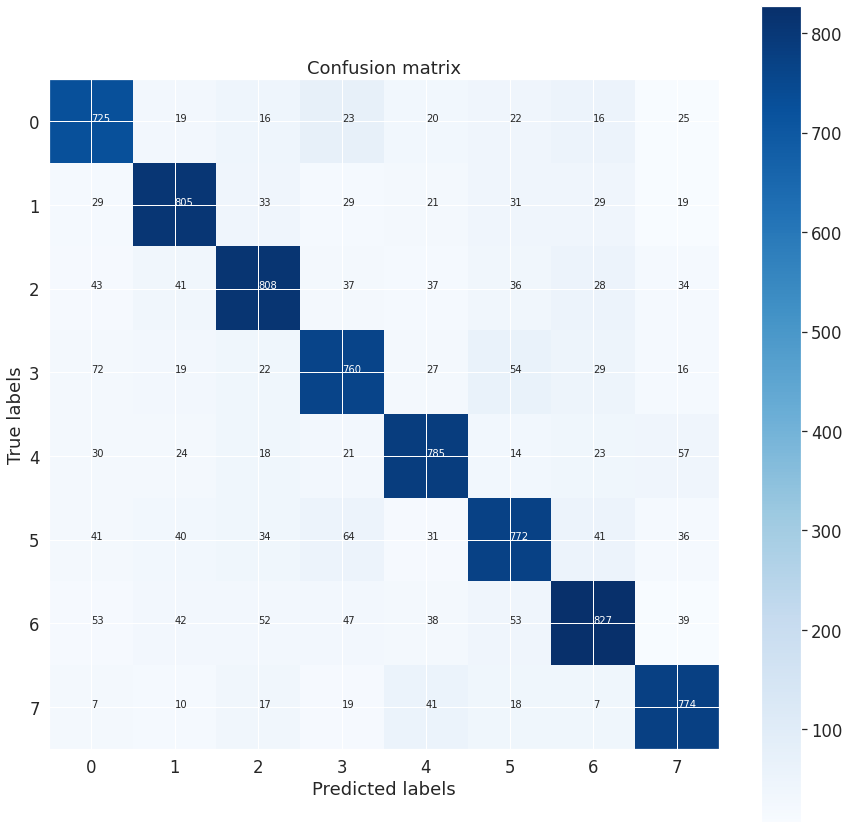

In [87]:
trueOutput = [np.where(r==1)[0][0] for r in encodedOutputLabelList]
predictedOutput = model3.predict_classes(combinedFeatureList)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(trueOutput, predictedOutput)

%matplotlib inline
plt.figure(figsize = (15, 15))
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion matrix')
for i in range(8):
  for j in range(8):
    if i==j:
      plt.annotate(cm[i][j], (i, j), color = 'white')
    else:
      plt.annotate(cm[i][j], (i, j))
plt.colorbar()
plt.show()